# Bayesian Optimization for Hyper-Parameter Tuning

In this notebook I have implemented Bayesian Optimization using Gaussian Processes for tuning the hyper parameters of an LSTM neural network. The library I utilized was scikit optimize. 

The general idea behind this hyper parameter tuning is to approximate the underlying true fitness value (in this case I am optimizing for F.5 score as my fitness value). It first spreads out its guesses to get a general idea about the search space and how it relates to the fitness value. Once it has done this step, it begins trying to exploit areas with better fitness values.

In this notebook I showcase an optimization for F.5 score. The idea behind optimizing this value is that I would prefer if my precision is higher so that I minimize the risk of making an investment. Not identifying every opportunity for investment(recall) does not need to be optimized as much, as I am losing nothing if I miss out.

I will be optimizing on my SPY dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

parameters to optimize:
 - adam learning rate
 - number of layers
 - number of nodes
 - dropout rate

In [3]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_layers = Integer(low=1, high=8, name='num_layers')
dim_num_nodes = Integer(low=5, high=256, name='num_nodes')
dim_dropout_rate = Real(low=0.05, high=.8, name='dropout_rate')

In [4]:
# combine dimensions into a list
dimensions = [dim_learning_rate,
              dim_num_layers,
              dim_num_nodes,
              dim_dropout_rate]

Start off with some good default parameters

In [5]:
defaults = [1e-3, 1, 16, .2]

Bringing in some helper functions for preprocessing from other notebooks.

In [6]:
# first we define some data processing functions to load the data
def class_separation(x):
    if x < -.05:
        return -2
    elif x < -.005:
        return -1
    elif x > .05:
        return 2
    elif x > .005:
        return 1
    else:
        return 0

def scale(in_train, in_val, in_test):
    '''
    Rescales the train and test sets
    Args:
        train -> numpy array of the training data
        test -> numpy array of the test data
        with_labels -> if set to true will cut off last column before scaling,
            reattached after scaling
    Returns:
        scaler -> the scaler object for transforming
        train_scaled -> a rescaled version of the train data
        test_scaled -> a rescaled version of the test data
    '''
    train = in_train
    val = in_val
    test = in_test
    # scale train and test to [-1,1]
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform validation
    val = val.reshape(val.shape[0], val.shape[1])
    val_scaled = scaler.transform(val)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, val_scaled, test_scaled

def split_data(data, val_percent=.2, test_percent=.2):
    '''
    Splits the data by percentage amount
    Returns: train, test
    '''
    test_split = int(len(data) * (1 - test_percent))
    val_split = test_split - int(len(data) * (val_percent))
    train, val, test = data[:val_split], data[val_split:test_split], data[test_split:]
    return train, val, test

# helper function for one of our technical indicators
def calc_rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df.adj_close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi
    
def add_features(df):
    # accumulation/Distribution line
    mult = ((df.close - df.low) - (df.high - df.close)) / (df.high - df.low)
    MFVolume = mult * df.volume
    accum_dist_indicator = MFVolume.cumsum()
    ret_df = pd.concat([df, accum_dist_indicator], axis=1)
    ret_df = ret_df.rename(mapper={0:'accum_dist_indicator'}, axis=1)

    #MACD
    EMA_12 = df.adj_close.ewm(span=12, adjust=False).mean()
    EMA_26 = df.adj_close.ewm(span=26, adjust=False).mean()
    macd = EMA_12 - EMA_26
    signal = macd.ewm(span=9, adjust=False).mean()
    ret_df = pd.concat([ret_df, macd.rename('macd'), signal.rename('signal_macd')], axis=1)

    #RSI
    rsi = calc_rsi(df)
    ret_df = pd.concat([ret_df, rsi.rename('rsi')], axis=1)
    
    return ret_df

def read_data(filename):
    # read in the data
    data = pd.read_csv(filename)
    data = data.rename(str.lower, axis=1)
    data = data.rename(mapper={'adj close': 'adj_close'}, axis=1)
    data.date = pd.to_datetime(data.date)
    data = data.set_index('date')
    return data

def series_to_supervised(data, n_in=1, n_out=1, col_names = [], indicies = [], preds = [], dropnan=True):
    '''
    Convert a time series to a supervised learning dataset
    Args:
        data -> time series to convert as a list or numpy array
        n_in -> number of lag observations as input (X)
        n_out -> number of observations as output (y)
        col_names -> names of the columns
        indicies -> list of the indicies
        preds -> list of column indicies to determine which variables to predict
        dropnan -> flag of whether to drop the rows with NaN
    Returns:
        Pandas DataFrame of series framed for supervised learning
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence
    for i in range(0, n_out):
        cols.append(df[col_names[preds]].shift(-i))
        if i==0:
            names += [('%s(t)' % (col_names[j])) for j in preds]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in preds]
    # putting it together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = indicies
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def prep_data(filename, lookback=14):
    temp = np.array([0,1,2,-1,-2]).reshape(-1,1)
    # read in the data
    data = read_data(filename)
    data = data
    # add technical indicators as features
    data = add_features(data)
    # frame as an RNN problem
    data = series_to_supervised(data, lookback, 5, data.columns, data.index, [4])
    # only keep the predictive columns I care about
    data = data.drop(data.columns[-5:-1], axis=1)
    labels = (data['adj_close(t+4)'] - data['adj_close(t-1)']) / data['adj_close(t-1)']
    labels = labels.apply(class_separation)
    data = data.drop(data.columns[-1], axis=1)
    data = pd.concat([data, labels.rename('labels')], axis=1)
    data_values = data.values
    train, val, test = split_data(data_values, .2, .2)
    scaler, train_scaled, val_scaled, test_scaled = scale(train[:,:-1], val[:,:-1], test[:,:-1])
    ohe = OneHotEncoder(sparse=False).fit(temp)
    train_scaled = np.append(train_scaled, ohe.transform(train[:,-1].reshape((-1,1))), axis=1)
    val_scaled = np.append(val_scaled, ohe.transform(val[:,-1].reshape((-1,1))), axis=1)
    test_scaled = np.append(test_scaled, ohe.transform(test[:,-1].reshape((-1,1))), axis=1)
    return scaler, train_scaled, val_scaled, test_scaled


In [7]:
# now we read in our data
scaler, train, val, test = prep_data('../../data/SPY_1993-01-29_2022-08-17.csv')

Split is set up as `.6:.2:.2` for training, validation, and test sets respectively.

In [8]:
print(len(train), len(val), len(test))

4446 1482 1482


In [9]:
# making the models based on inputs
def create_model(learning_rate, num_layers, num_nodes, dropout_rate, shape, batch_size=32):
    '''
    Learning_rate: learning rate for optimizer
    num_layers: number of LSTM layers to use
    num_nodes: how many nodes for each layer
    dropout_rate: the dropout rate to pass to the LSTMs
    '''
    model = Sequential()
    for i in range(num_layers - 1):
        model.add(LSTM(num_nodes,
                       batch_input_shape=(batch_size, shape[1], shape[2]),
                       stateful = True,
                       return_sequences=True,
                       dropout=.2))
    
    model.add(LSTM(num_nodes,
                   batch_input_shape=(batch_size, shape[1], shape[2]),
                   stateful=True,
                   dropout=dropout_rate))
    
    model.add(Dense(5, activation='softmax'))
    
    opt = Adam(learning_rate=learning_rate)
    
    prec = tf.keras.metrics.Precision()
    rec = tf.keras.metrics.Recall()
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=[prec,
                           rec,
                           'AUC',
                           'accuracy'])
    
    return model

In [10]:
filename = 'bestmodel.h5'
best_fscore = -1

Define

In [11]:
batch_size = 64
nb_epochs = 250

In [12]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.reset_states()
        print(epoch,',',sep='', end='')

def fitness(x):
    '''
    Learning_rate: learning rate for optimizer
    num_layers: number of LSTM layers to use
    num_nodes: how many nodes for each layer
    dropout_rate: the dropout rate to pass to the LSTMs
    '''
    # Clear the keras session
    tf.keras.backend.clear_session()
    
    learning_rate = x[0]
    num_layers = x[1]
    num_nodes = x[2]
    dropout_rate = x[3]
    
    # Print the hyper-parameters
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_layers:', num_layers)
    print('num_nodes:', num_nodes)
    print('dropout rate:', dropout_rate)
    print()
        
    train_trimmed = train[len(train)%batch_size:]
    X, y = train_trimmed[:,:-5], train_trimmed[:,-5:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = create_model(learning_rate, num_layers, num_nodes, dropout_rate, X.shape, batch_size)

    val_trimmed = val[:-(len(val)%batch_size)] if len(val) % batch_size != 0 else val
    x_val, y_val = val_trimmed[:,:-5], val_trimmed[:,-5:]
    x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])
    history = model.fit(X, y,
                        epochs=nb_epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[CustomCallback(), EarlyStopping(patience=5, restore_best_weights=True)],
                        verbose=False,
                        shuffle=False)
    
    # get validation loss after last epoch
    loss = history.history['val_loss'][-1]
    accuracy = history.history['val_accuracy'][-1]
    prec = history.history['val_precision'][-1]
    rec = history.history['val_recall'][-1]
    auc = history.history['val_auc'][-1]
    
    if prec < .00001:
        f_05 = 0
    else:
        f_05 = (1.25 * prec * rec) / (.25*prec + rec)
    
    print()
    print()
    print("val_loss: %.4f"%(loss))
    print('val_accuracy: %.4f'%(accuracy))
    print('val_precision: %.4f'%(prec))
    print('val_recall: %.4f'%(rec))
    print('val_f.5: %.4f' %(f_05))
    print('val_auc: %.4f'%(auc))
    print()
    
    global best_fscore
    if f_05 > best_fscore:
        model.save(filename)
        best_fscore = f_05
    
    del model
    
    # Clear the keras session
    tf.keras.backend.clear_session()
    
    # this is a minimization, so we negate the value as we wish for maximizing this value
    return -f_05

In [13]:
# check model functionality
fitness(x=defaults)

learning rate: 1.0e-03
num_layers: 1
num_nodes: 16
dropout rate: 0.2

0,1,2,3,4,5,6,7,8,9,10,11,

val_loss: 1.5787
val_accuracy: 0.2018
val_precision: 0.4734
val_recall: 0.0543
val_f.5: 0.1862
val_auc: 0.5747



-0.1862197358729714

Now we run the gaussian process for minimization of this fitness value.

In [14]:
search_result = gp_minimize(func=fitness, dimensions=dimensions, acq_func='EI', n_calls=40, x0=defaults)

learning rate: 1.0e-03
num_layers: 1
num_nodes: 16
dropout rate: 0.2

0,1,2,3,4,5,6,7,8,9,10,

val_loss: 1.2134
val_accuracy: 0.4124
val_precision: 0.5294
val_recall: 0.0245
val_f.5: 0.1032
val_auc: 0.7899

learning rate: 1.1e-04
num_layers: 1
num_nodes: 200
dropout rate: 0.15753529283330725

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,

val_loss: 1.2461
val_accuracy: 0.3981
val_precision: 0.4482
val_recall: 0.1440
val_f.5: 0.3151
val_auc: 0.7813

learning rate: 1.0e-04
num_layers: 1
num_nodes: 126
dropout rate: 0.5927142247503736

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,

val_loss: 1.2809
val_accuracy: 0.3682
val_precision: 0.4529
val_recall: 0.0686
val_f.5: 0.2136
val_auc: 0.7654

learning rate: 3.9e-04
num_layers: 4
num_nodes: 111
dropout rate: 0.4580939064182011

0,1,2,3,4,5,6,

val_loss: 1.1877
val_accuracy: 0.4592
val_precision: 0.0000
val_recall: 0.0000
val_f.5: 0.0000
val_auc: 0.7885

learning rate: 5.7e-03
num_layers: 7
num_nodes: 113
dropout rate: 0.6597918

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,

val_loss: 1.3141
val_accuracy: 0.4443
val_precision: 0.4867
val_recall: 0.2480
val_f.5: 0.4081
val_auc: 0.7610

learning rate: 1.0e-06
num_layers: 8
num_nodes: 5
dropout rate: 0.7432362828818864

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,12

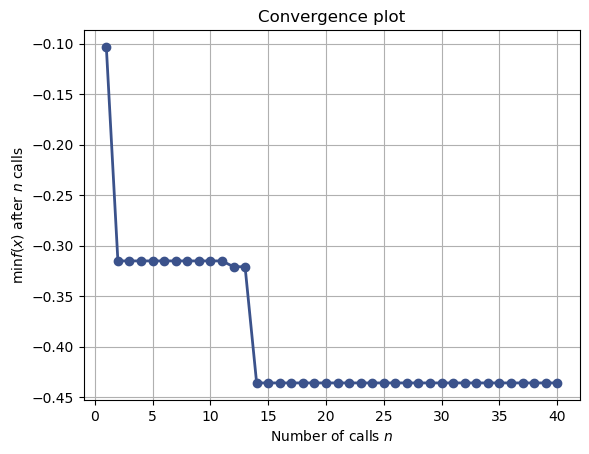

In [15]:
plot_convergence(search_result)

These are the resulting hyper-parameters for the best network that was found

In [16]:
search_result.x

[2.235768703079791e-05, 1, 190, 0.05]

In [17]:
# final fitness value
search_result.fun

-0.4359211317163373

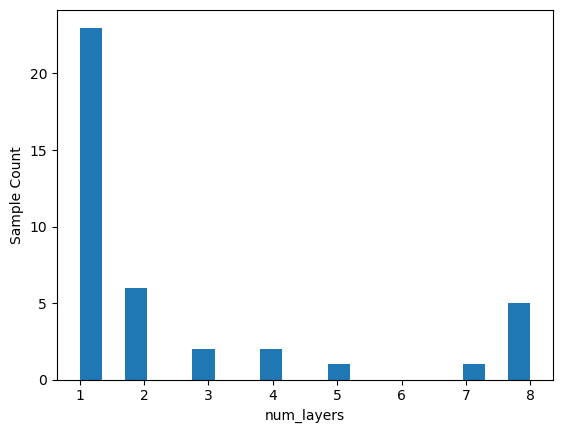

In [18]:
plot_histogram(result=search_result, dimension_identifier='num_layers');

In [19]:
dim_names = ['learning_rate','num_layers', 'num_nodes', 'dropout_rate']

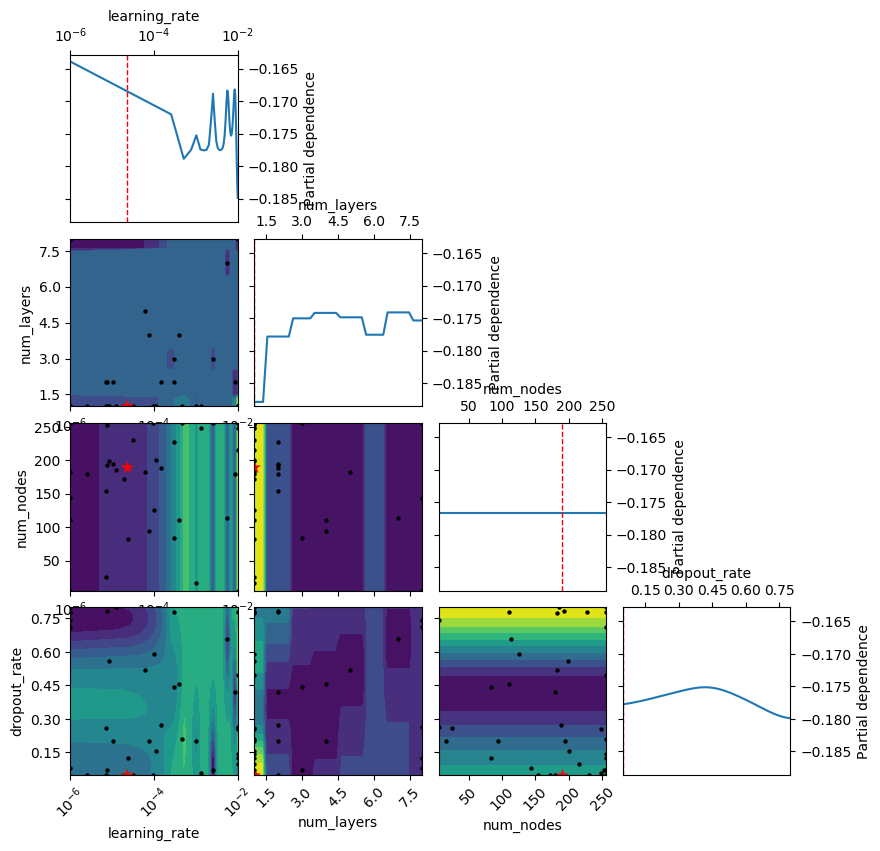

In [20]:
plot_objective(result=search_result, dimensions=dim_names);

Pretty interesting to see the search space approximations

### Evaluate best model on the test set

In [21]:
from keras.models import load_model

model = load_model(filename)

In [22]:
model.reset_states()
# run the validation through the model to set the state
val_trimmed = val[(len(val)%batch_size):] if len(val) % batch_size != 0 else val
X, y = val_trimmed[:,:-5], val_trimmed[:,-5:]
X = X.reshape(X.shape[0], 1, X.shape[1])
model.predict(X, batch_size=batch_size)

# now we measure performance on the test set
test_trimmed = test[:-(len(test)%batch_size)] if len(test) % batch_size != 0 else test
x_test, y_test = test_trimmed[:,:-5], test_trimmed[:,-5:]
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

result = model.evaluate(x_test, y_test, batch_size=batch_size)

23/23 [==============================] - 1s 6ms/step - loss: 1.3807 - precision: 0.4760 - recall: 0.4708 - auc: 0.7196 - accuracy: 0.4755


In [23]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 1.3807228803634644
precision 0.4759615361690521
recall 0.47078803181648254
auc 0.7195753455162048
accuracy 0.47554346919059753


Now we will compare this to a model I hand optimized in a different notebook.

In [29]:
# import and test the previous model
other_model = load_model('../models/SPY-model.h5')

In [31]:
batch_size = 32
# run the validation through the model to set the state
val_trimmed = val[(len(val)%batch_size):] if len(val) % batch_size != 0 else val
X, y = val_trimmed[:,:-5], val_trimmed[:,-5:]
X = X.reshape(X.shape[0], 1, X.shape[1])
other_model.predict(X, batch_size=batch_size)

# now we measure performance on the test set
test_trimmed = test[:-(len(test)%batch_size)] if len(test) % batch_size != 0 else test
x_test, y_test = test_trimmed[:,:-5], test_trimmed[:,-5:]
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

result = other_model.evaluate(x_test, y_test, batch_size=batch_size)

46/46 [==============================] - 1s 7ms/step - loss: 1.5768 - precision_1: 0.3499 - recall_1: 0.1766 - auc: 0.6594


In [32]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 1.5767508745193481
precision 0.3499327003955841
recall 0.176630437374115
auc 0.6594195365905762


By comparison, the bayesian optimized model performs better than my hand trained model

In [24]:
search_result.x

[2.235768703079791e-05, 1, 190, 0.05]

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 190)                 251560    
                                                                 
 dense (Dense)               (64, 5)                   955       
                                                                 
Total params: 252,515
Trainable params: 252,515
Non-trainable params: 0
_________________________________________________________________


In [26]:
train_trimmed = train[len(train)%batch_size:]
X, y = train_trimmed[:,:-5], train_trimmed[:,-5:]
X = X.reshape(X.shape[0], 1, X.shape[1])

result = model.evaluate(X, y, batch_size=batch_size)

69/69 [==============================] - 0s 6ms/step - loss: 1.2171 - precision: 0.5347 - recall: 0.0122 - auc: 0.7929 - accuracy: 0.4389


In [27]:
model.reset_states()
# run the validation through the model to set the state
train_trimmed = train[(len(train)%batch_size):] if len(train) % batch_size != 0 else train
X, y = train_trimmed[:,:-5], train_trimmed[:,-5:]
X = X.reshape(X.shape[0], 1, X.shape[1])
model.predict(X, batch_size=batch_size)

val_trimmed = val[:-(len(val)%batch_size)] if len(val) % batch_size != 0 else val
X, y = val_trimmed[:,:-5], val_trimmed[:,-5:]
X = X.reshape(X.shape[0], 1, X.shape[1])
result = model.evaluate(X, y, batch_size=batch_size)

23/23 [==============================] - 0s 6ms/step - loss: 1.3324 - precision: 0.4510 - recall: 0.2751 - auc: 0.7689 - accuracy: 0.4592  


In [28]:
pd.DataFrame(y).describe()

,0,1,2,3,4
count,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,0.013587,0.271739,0.243207,0.459239,0.012228
std,0.115808,0.445007,0.429165,0.498505,0.109941
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000
